4-split model using a single CAE with separable convolutions. By using 32x32 (rescaled) input images we can avoid padding in the encoder. Thereby we can show the equivalance of this model to the 4-split micae. The decoder has a different structure (convolution with overlap + additional Dense layer after input).

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [21]:
from skimage.transform import resize

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = resize(x_train, (x_train.shape[0], 32, 32, 1))
x_test = resize(x_test, (x_test.shape[0], 32, 32, 1))

0.99215686


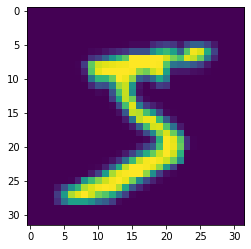

In [22]:
plt.imshow(x_train[0].reshape(32,32))
print(np.amax(x_train[0]))

Create sequential CAE model

In [23]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(32,32,1), name='enc_in'),
#         tf.keras.layers.InputLayer(input_shape=(28,28,1), name='enc_in'),
#         tf.keras.layers.Conv2D(filters=int(32), kernel_size=(3,3), strides=(3,3), activation='relu', padding='valid', use_bias=True, name='conv1'),
        tf.keras.layers.Conv2D(filters=int(32), kernel_size=(4,4), strides=(4,4), activation='relu', padding='valid', use_bias=True, name='conv1'),
        tf.keras.layers.Conv2D(filters=int(64), kernel_size=(2,2), strides=(2,2), activation='relu', padding='valid', use_bias=True, name='conv2'),
        tf.keras.layers.Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='sigmoid', padding='valid', name='pt_conv'),
        tf.keras.layers.Flatten(name='latent'),
        
        tf.keras.layers.Dense(units=8*8*32, activation='relu', name='dense'),
        tf.keras.layers.Reshape(target_shape=(8, 8, 32), name='reshape'),
#         tf.keras.layers.Dense(units=7*7*32, activation='relu', name='dense'),
#         tf.keras.layers.Reshape(target_shape=(7, 7, 32), name='reshape'),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='deconv1'),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='deconv2'),
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', name='dec_out')
    ]
)
model.compile(loss='mse', optimizer='adam')

In [24]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 8, 8, 32)          544       
_________________________________________________________________
conv2 (Conv2D)               (None, 4, 4, 64)          8256      
_________________________________________________________________
pt_conv (Conv2D)             (None, 4, 4, 1)           65        
_________________________________________________________________
latent (Flatten)             (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 2048)              34816     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 32)          0         
_________________________________________________________________
deconv1 (Conv2DTranspose)    (None, 16, 16, 64)       

In [25]:
history = model.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=20, batch_size=32, shuffle=True)

Epoch 1/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0248 - val_loss: 0.0174
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0161 - val_loss: 0.0151
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0147 - val_loss: 0.0141
Epoch 4/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 5/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 6/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 7/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0126 - val_loss: 0.0123
Epoch 8/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 9/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 10/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.01

In [ ]:
n_epochs=100
model.save('../models/micae4splitV3_%depochs'%n_epochs)

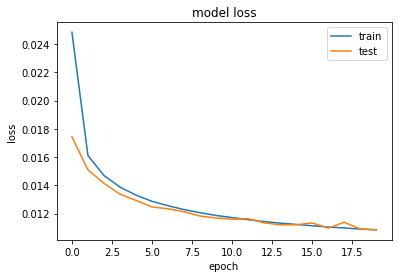

In [26]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Plot input, 4x4 activations of latent space and output.

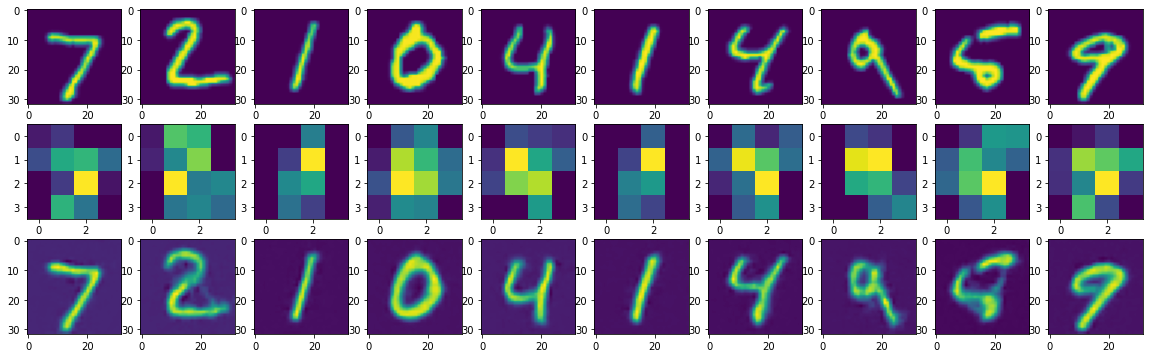

In [28]:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=[model.get_layer('pt_conv').output, model.output])

plt.figure(figsize=(20, 6))
n = 10
for i in range(n):
    out1, out = activation_model.predict(x_test[i].reshape(1,32,32,1))
#     out1, out = activation_model.predict(x_test[i].reshape(1,28,28,1))
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(32,32))
#     plt.imshow(x_test[i].reshape(28,28))
    ax = plt.subplot(3, n, n+i+1)
    plt.imshow(out1.reshape(4,4))
#     plt.imshow(out1.reshape(8,8))
    ax = plt.subplot(3, n, 2*n+i+1)
    plt.imshow(out.reshape(32,32))
#     plt.imshow(out.reshape(28,28))

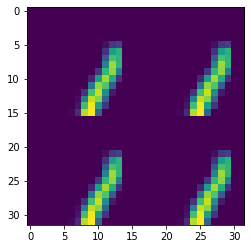

In [29]:
quad1 = x_test[4][:16, :16]
# quad1 = x_test[4][:14, :14]
quad12 = np.vstack((quad1,quad1))
full = np.hstack((quad12,quad12))
plt.imshow(full.reshape(32,32))
# plt.imshow(full.reshape(28,28))

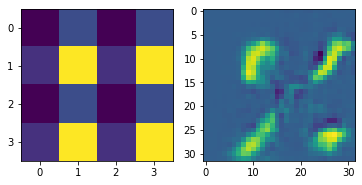

In [31]:
out1, out = activation_model.predict(full.reshape(1,32,32,1))
# out1, out = activation_model.predict(full.reshape(1,28,28,1))
ax = plt.subplot(1, 2, 1)
plt.imshow(out1.reshape(4,4))
ax = plt.subplot(1, 2, 2)
plt.imshow(out.reshape(32,32))
# plt.imshow(out.reshape(28,28))